# Setup

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
# constants and global variables
DATA_PATH = 'twitter-datasets/{}'
MODEL_PATH = 'models/{}'

# if set to true the trainig of the classifier models will be performed, otherwise the 
# models will be loaded from a file (if present)
is_train_enabled = False

# Read Preprocessed Data

In [3]:
def load_X_data(file_name):
  tweets = []
  with open(DATA_PATH.format(file_name), 'r', encoding='utf-8') as f:
      for line in f:
        tweets.append(line.rstrip().split())
  
  return np.array(tweets)

X_train = load_X_data("X_train_processed.txt")
X_test = load_X_data("X_test_processed.txt")

X_train = list(map(lambda tweet : " ".join(tweet), X_train))
X_test = list(map(lambda tweet : " ".join(tweet), X_test))

D:\miniconda3\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [4]:
def load_y_data(file_name):
  labels = []
  with open(DATA_PATH.format(file_name), 'r', encoding='utf-8') as f:
      for line in f:
        labels.append(int(line.rstrip()))
  
  return np.array(labels)

y_train = load_y_data("y_train.txt")

# TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

vectorizer = TfidfVectorizer()
scaler =  StandardScaler(with_mean=False)

# Fit the tfidf model
vectorizer = vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Fit the scaler
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape is {}".format(X_train.shape))
print("X_test shape is {}".format(X_test.shape))

X_train shape is (200000, 87929)
X_test shape is (10000, 87929)


# Visualization

In [6]:
from sklearn.model_selection import train_test_split

# split the model into training test and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [7]:
from sklearn.manifold import TSNE

tnse = TSNE(n_components=2, n_iter=3000, metric='cosine', n_jobs=-1, init='random', square_distances='legacy')
tfidf_tsne = tnse.fit_transform(X_val)

D:\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


Text(0.5, 1.0, '')

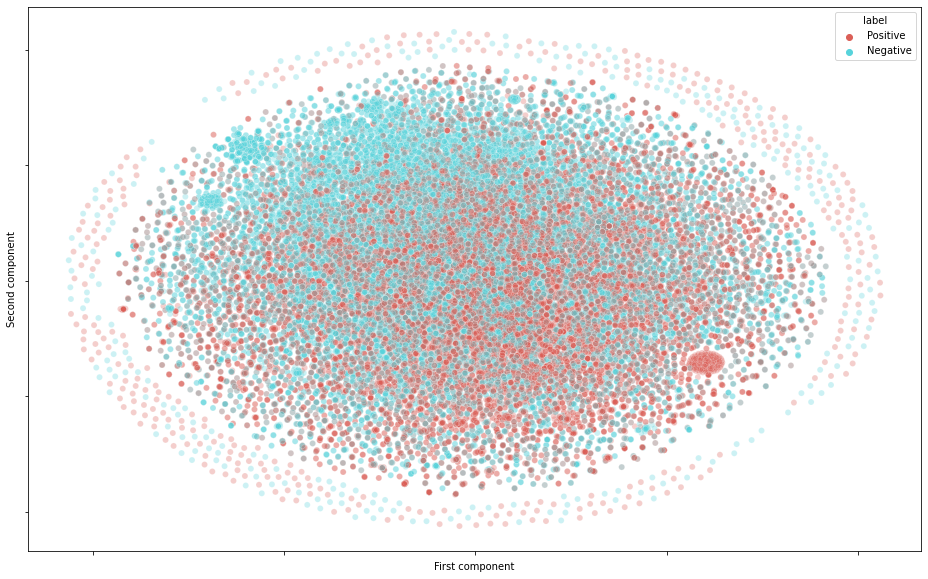

In [8]:
import seaborn as sns
sns.axes_style("whitegrid")

df = pd.DataFrame()
df['tsne-2d-one'] = tfidf_tsne[:,0]
df['tsne-2d-two'] = tfidf_tsne[:,1]
df['label'] = pd.Series(y_val).apply(lambda label: "Positive" if label==1 else "Negative")

fig = plt.figure(figsize = (16,10))

targets = ['Negative', 'Positive']

ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend=targets,
    alpha=0.3    
)

ax.grid(False)
ax.set(xticklabels=[], yticklabels=[])
ax.set(xlabel='First component', ylabel='Second component')
ax.set_title(label='')

# Models
Apply standard machine learning models to the words embeddings that come out of TF-IDF.

## Linear models

### SVM

In [9]:
from sklearn.svm import LinearSVC
# define model
model = LinearSVC(class_weight='balanced', random_state=42)

In [10]:
from joblib import dump, load

# train model
if is_train_enabled:
  model.fit(X_train, y_train)
  dump(model, MODEL_PATH.format('svc_tf_idf.joblib')) 

In [11]:
# load the trained model from file
model = load(MODEL_PATH.format('svc_tf_idf.joblib')) 

In [12]:
from sklearn.metrics import f1_score, accuracy_score

# Plotting scores
y_pred = model.predict(X_val)

f1 = f1_score(y_val, y_pred, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_val, y_pred)
print("Test accuracy score : %s "% acc)

Test f1 score : 0.7932599750394734 
Test accuracy score : 0.793275 


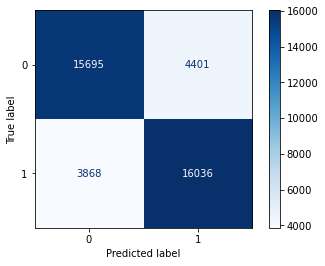

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Non-linear models

### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
# define model
model = RandomForestClassifier(class_weight='balanced', random_state=42)

In [15]:
# train model
if is_train_enabled:
  model.fit(X_train, y_train)
  dump(model, MODEL_PATH.format('random_forest_tf_idf.joblib')) 

In [16]:
# load the trained model from file
model = load(MODEL_PATH.format('random_forest_tf_idf.joblib')) 

In [17]:
# Plotting scores
y_pred = model.predict(X_val)

f1 = f1_score(y_val, y_pred, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_val, y_pred)
print("Test accuracy score : %s "% acc)

Test f1 score : 0.9366645825509534 
Test accuracy score : 0.936675 


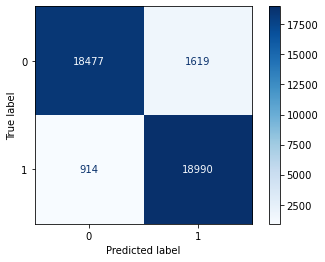

In [18]:
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot(cmap=plt.cm.Blues)
plt.show()